In [288]:
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

class Results:
    def __init__(self, measure, dataset_name, model_name, specific_train_route=None, x=4):
        self.dataset_name = dataset_name
        self.model_name = model_name
        self.specific_train_route = specific_train_route
        self.x = x
        self.measure = measure
        self.relative_path = f'Results/Separate_Runs/{dataset_name}/{model_name}/*results365.csv'
        self.data = self.data_from_files(self.relative_path, self.measure)
        self.data_route = self.extract_train_routes(specific_train_route, self.data)
    
    def data_from_files(self, relative_path, measure):
        file_list_results = glob.glob(relative_path)
        
        result_df = pd.DataFrame()

        for file in file_list_results:
            index_start = len(relative_path.split('*')[0])
            data_from_file = pd.read_csv(file)
            file_dict = {}
            file_dict['route_station'] = file[index_start:].split('_')[0]
            for i in range(self.x):
                file_dict[f'{measure}_baseline{i}'] = data_from_file[f'{measure}_baseline{i}'][0]
                file_dict[f'{measure}_ARIMA{i}'] = data_from_file.get(f'{measure}_ARIMA{i}', [None])[0] # No ARIMA column in only Boosted
                file_dict[f'{measure}_full{i}'] = data_from_file[f'{measure}_full{i}'][0]
            result_df = pd.concat([result_df, pd.DataFrame(file_dict, index=[0])])
        return result_df
    
    def extract_train_routes(self, specific_train_route, data):
        return data[data['route_station'].str.startswith(f'({specific_train_route},')]
    
    def plot_function():
        print('Not implemented...')
    def plot_caller():
        print('Not implemented')
    

In [289]:
class Errors(Results):
    def __init__(self, dataset_name, model_names, specific_train_route=None, x=4):
        super().__init__('Error', dataset_name, model_names, specific_train_route, x)
        
    def error_plot_across_days(self, df):
        df = df.sort_values(by='route_station')
        col_names = np.unique([i[:-1] for i in df.columns[:-1]])
        col_names = col_names[col_names != 'Error_baseline']

        bar_width = 0.2
        num_predictions = self.x  # Assuming self.x holds the number of predictions into the future
        p= 1- 3* bar_width
        colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
        fig, ax = plt.subplots()
        ax.bar(0, df[f'Error_baseline0'], bar_width, label=f'Error_baseline')
        location = []

        for model_name in col_names:
            for i in range(num_predictions):
                ax.bar(p + i*bar_width, df[f'{model_name}{i}'], bar_width, color=colors[i])
                location += [p + i*bar_width]
            p += 1
        ax.set_xlabel('\nModel and Predicted days')
        ax.set_ylabel('Error')
        ax.set_title('Error Comparison across models')
        ax.set_xticks(location)
        ax.set_xticklabels([i + 1 for i in range(num_predictions)] * len(col_names))
        ax.grid()
        sec = ax.secondary_xaxis(location=0)
        sec_ticks = [0]
        sec_tick_labels = ['\nBaseline']
        for i, model_name in enumerate(col_names):
            sec_ticks.append(i+1 - 1.5 * bar_width)
            sec_tick_labels.append('\n' + model_name.split('_')[-1].capitalize())
        sec.set_xticks(sec_ticks)
        sec.set_xticklabels(sec_tick_labels)
        plt.tight_layout()
        plt.show()

    def error_plot(self, df):
        df = df.sort_values(by='route_station')

        bar_width = 0.25
        index = range(len(df))
        # Plot baseline errors
        plt.bar(index, df['Error_baseline0'], bar_width, label='Baseline')
        # Plot ARIMA errors if available
        displacement = 1
        if 'Error_ARIMA0' in df.columns:
            plt.bar([i + bar_width for i in index], df['Error_ARIMA0'], bar_width, label='ARIMA')
            displacement = 2
        # Plot full errors
        plt.bar([i + displacement*bar_width for i in index], df['Error_full0'], bar_width, label='Full')

        plt.xlabel('(Route, Station)')
        plt.ylabel('Error')
        plt.title('Error comparison for (Route, Station) pairs')

        if displacement == 1:
            plt.xticks([i + bar_width/2 for i in index], df['route_station'])
        else: plt.xticks([i + bar_width for i in index], df['route_station'])

        plt.legend(loc='upper right')
        plt.tight_layout()
        plt.grid()
        plt.show()

    def error_function(self, use_mean=False, use_across_days=False):
        if use_mean or use_across_days:
            mean_errors = pd.DataFrame(self.data.mean(axis=0, numeric_only=True)).T
            mean_errors = mean_errors.assign(route_station='Mean')
            if use_mean:
                self.error_plot(mean_errors)
            else:
                self.error_plot_across_days(mean_errors)
        else:
            self.error_plot(self.data_route)

In [317]:
ARIMA_XGBoost_Errors = Errors('Cleaned', 'ARIMA_XGBoost', 20)
ARIMA_CatBoost_Errors = Errors('Cleaned', 'ARIMA_Catboost', 20)

In [323]:
def plot_columns(data_classes, column, column_arima=None, use_mean=False):
    datasets = data_classes

    plt.figure(figsize=(10,7))
    bar_width = 0.15
    index = range(0,1)
    arima_found=False
    plt.bar([j + bar_width for j in index], (pd.DataFrame(datasets[0].data.mean(axis=0, numeric_only=True)).T.assign(route_station='Mean'))['Error_baseline0'], bar_width, label='Baseline')
    counter = 0
    for i, (dataset) in enumerate(datasets):
        dataset_df = (pd.DataFrame(dataset.data.mean(axis=0, numeric_only=True)).T.assign(route_station='Mean')).sort_values(by='route_station')
        plt.bar([j + (counter+2) * bar_width for j in index], dataset_df[column].values, bar_width, label=dataset.model_name)
        counter += 1
        if column_arima in dataset_df.columns and not arima_found:
            plt.bar([j + (counter+2) * bar_width for j in index], dataset_df[column_arima].values, bar_width, label='ARIMA')
            counter += 1
            arima_found=True
        #plt.xticks(1, dataset_df['route_station'])
        #print(dataset)
    
    plt.legend()
    plt.title(f'Error full on {dataset.dataset_name} data')
    plt.grid()


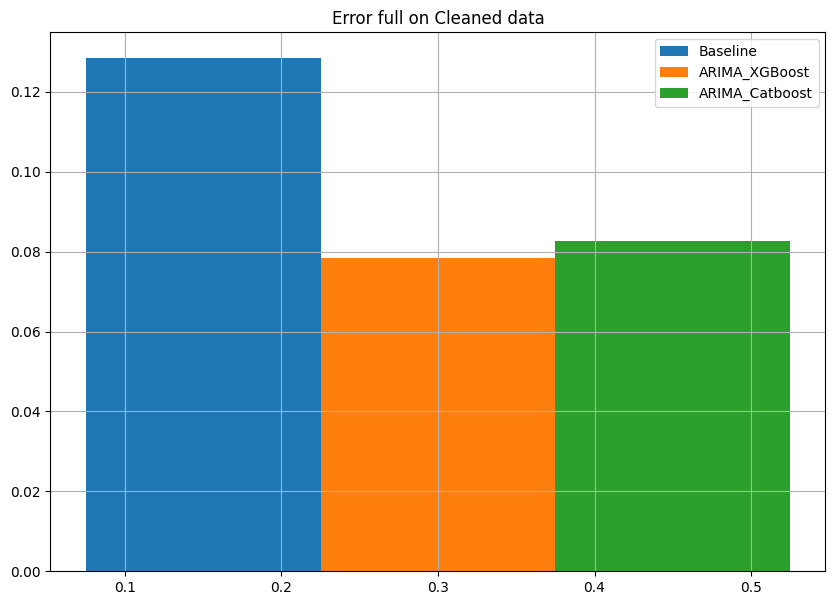

In [324]:
plot_columns([ARIMA_XGBoost_Errors, ARIMA_CatBoost_Errors], 'Error_full0', column_arima='Errors_ARIMA0', use_mean=True)

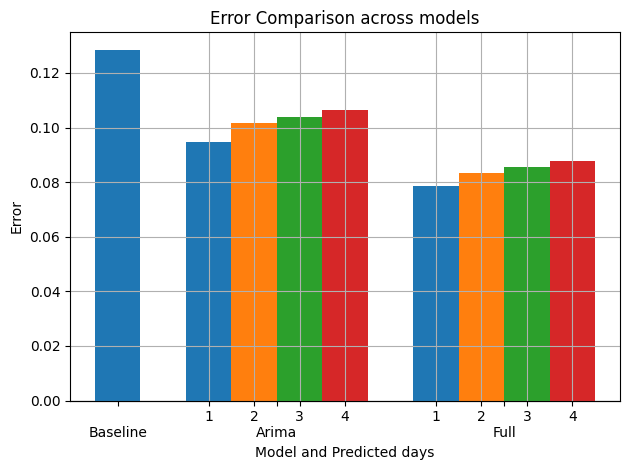

In [284]:
test.data_route
test.error_function(use_mean=False, use_across_days=True)

In [252]:
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

class Errors:
    def __init__(self, dataset_name, model_names, specific_train_route=None, x=4):
        self.dataset_name = dataset_name
        self.model_names = model_names
        self.specific_train_route = specific_train_route
        self.x = x
        self.error_df = self.data_from_files_error(f'Results/Separate_Runs/{dataset_name}/{model_names}/*results365.csv')
        self.error_df_route = self.extract_train_routes(specific_train_route, self.error_df)

    def data_from_files_error(self, relative_path):
        file_list_results = glob.glob(relative_path)
        
        result_df = pd.DataFrame()

        for file in file_list_results:
            index_start = len(relative_path.split('*')[0])
            data_from_file = pd.read_csv(file)
            file_dict = {}
            file_dict['route_station'] = file[index_start:].split('_')[0]
            for i in range(self.x):
                file_dict[f'Error_baseline{i}'] = data_from_file[f'Error_baseline{i}'][0]
                file_dict[f'Error_ARIMA{i}'] = data_from_file.get(f'Error_ARIMA{i}', [None])[0] # No ARIMA column in only Boosted
                file_dict[f'Error_full{i}'] = data_from_file[f'Error_full{i}'][0]
            result_df = pd.concat([result_df, pd.DataFrame(file_dict, index=[0])])
        return result_df

    def extract_train_routes(self, specific_train_route, errors_df):
        return errors_df[errors_df['route_station'].str.startswith(f'({specific_train_route},')]
    
    def error_plot_across_days(self, df):
        df = df.sort_values(by='route_station')
        col_names = np.unique([i[:-1] for i in df.columns[:-1]])
        col_names = col_names[col_names != 'Error_baseline']

        bar_width = 0.2
        num_predictions = self.x  # Assuming self.x holds the number of predictions into the future
        p= 1- 3* bar_width
        colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
        fig, ax = plt.subplots()
        ax.bar(0, df[f'Error_baseline0'], bar_width, label=f'Error_baseline')
        location = []

        for model_name in col_names:
            for i in range(num_predictions):
                ax.bar(p + i*bar_width, df[f'{model_name}{i}'], bar_width, color=colors[i])
                location += [p + i*bar_width]
            p += 1
        ax.set_xlabel('\nModel and Predicted days')
        ax.set_ylabel('Error')
        ax.set_title('Error Comparison across models')
        ax.set_xticks(location)
        ax.set_xticklabels([i + 1 for i in range(num_predictions)] * len(col_names))
        ax.grid()
        sec = ax.secondary_xaxis(location=0)
        sec_ticks = [0]
        sec_tick_labels = ['\nBaseline']
        for i, model_name in enumerate(col_names):
            sec_ticks.append(i+1 - 1.5 * bar_width)
            sec_tick_labels.append('\n' + model_name.split('_')[-1].capitalize())
        sec.set_xticks(sec_ticks)
        sec.set_xticklabels(sec_tick_labels)
        plt.tight_layout()
        plt.show()

    def error_plot(self, df):
        df = df.sort_values(by='route_station')

        bar_width = 0.25
        index = range(len(df))
        # Plot baseline errors
        plt.bar(index, df['Error_baseline0'], bar_width, label='Baseline')
        # Plot ARIMA errors if available
        displacement = 1
        if 'Error_ARIMA0' in df.columns:
            plt.bar([i + bar_width for i in index], df['Error_ARIMA0'], bar_width, label='ARIMA')
            displacement = 2
        # Plot full errors
        plt.bar([i + displacement*bar_width for i in index], df['Error_full0'], bar_width, label='Full')

        plt.xlabel('(Route, Station)')
        plt.ylabel('Error')
        plt.title('Error comparison for (Route, Station) pairs')

        if displacement == 1:
            plt.xticks([i + bar_width/2 for i in index], df['route_station'])
        else: plt.xticks([i + bar_width for i in index], df['route_station'])

        plt.legend(loc='upper right')
        plt.tight_layout()
        plt.grid()
        plt.show()

    def error_function(self, use_mean=False, use_across_days=False):
        if use_mean or use_across_days:
            mean_errors = pd.DataFrame(self.error_df.mean(axis=0, numeric_only=True)).T
            mean_errors = mean_errors.assign(route_station='Mean')
            if use_mean:
                self.error_plot(mean_errors)
            else:
                self.error_plot_across_days(mean_errors)
        else:
            self.error_plot(self.error_df_route)

    
    

In [277]:
test.error_df_route

AttributeError: 'Errors' object has no attribute 'error_df_route'

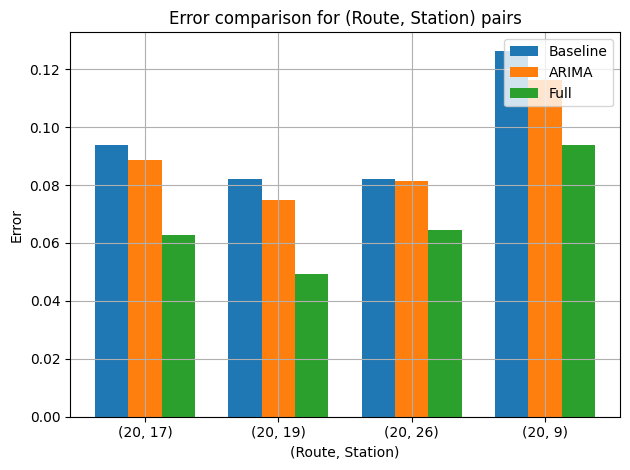

In [255]:
test.error_function(use_mean=False, use_across_days=False)